In [106]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow

from vbpp.model import VBPP
from data_up_events_training import make_estimate_data_for_up

def build_data(user, start_line, end_line, filename):
    #events_oral = make_estimate_data(user,start_line,end_line,filename)
    #events = np.unique(events_oral.flatten())
    events = make_estimate_data_for_up(user, start_line, end_line, filename)
    num_observations = len(events)
    #print(num_observations)
    return events, num_observations

def domain_grid(domain, num_points):       #域grid
    return np.linspace(domain.min(axis=1), domain.max(axis=1), num_points)

def domain_area(domain):                   #域面积
    return np.prod(domain.max(axis=1) - domain.min(axis=1))

def build_model(events, domain, num_observations, M=20, variance = 1.0, lengthscales = 0.5 ):
    #kernel = gpflow.kernels.SquaredExponential()
    kernel = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = lengthscales)
    Z = domain_grid(domain, M)                               #均匀切分domain,和events无关
    feature = gpflow.inducing_variables.InducingPoints(Z)    #inducing point（将均匀切分的点作为inducing point）
    q_mu = np.zeros(M)      #均值为0？
    q_S = np.eye(M)         #单位矩阵
    #print (events)
    num_events = len(events)
    beta0 = np.sqrt(num_events / domain_area(domain))       # 事件数/域面积 的开方,是什么？  是第二个模型的offset
    model = VBPP(feature, kernel, domain, q_mu, q_S, beta0=beta0, num_events=num_events, num_observations = num_observations)
    return model

In [107]:
N = 100     #预测点（lambda）
#目标用户信息,用于模型训练
object_user = 's047'
object_data_str = 0
object_data_end = 200

#kernel param
variance = 1.5
lengthscales = 0.5
inducing_num = 4

filename = "./data/DSL-StrongPasswordData.xls"
events,num_observations = build_data(object_user,object_data_str, object_data_end,filename)
events = np.array(events, float).reshape(-1, 1)

domain_max = max(events) + 0.03
domain = [0,domain_max]
domain = np.array(domain, float).reshape(1, 2)

model = build_model(events, domain, num_observations, M=inducing_num, variance=variance, lengthscales = lengthscales)   #M是 inducing point的数量

def objective_closure():                           #目标函数
    return - model.elbo(events)

gpflow.optimizers.Scipy().minimize(objective_closure, model.trainable_variables)

      fun: -481.10136968599386
 hess_inv: <21x21 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.86625958e+01, -3.63041070e+01,  7.25375099e+03,  1.02844970e+04,
       -4.19232657e+02,  7.40768466e+02, -7.55443280e+02,  1.88276629e+01,
        1.03675491e+02, -8.94176589e+01,  2.00702203e+01, -6.61493606e-01,
       -1.73682958e+00,  9.62833936e+00, -1.59146308e+01, -1.44274209e+00,
        3.24249515e+01, -2.06368274e+02,  2.82719249e+02,  2.95891160e+02,
       -1.18602606e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 70
      nit: 42
   status: 0
  success: True
        x: array([ 6.36259145e+01, -1.15052366e+00, -3.83605898e-02,  2.20686675e-01,
        8.10235318e-01, -1.02839936e+00,  2.12023716e+00,  4.22206009e+01,
       -6.04107690e+01, -6.04092129e+01,  4.22242063e+01,  5.87333696e-01,
        5.76750364e-01,  5.07930553e-01, -3.23775485e-01,  6.63511713e-01,
        1.16975113e-01, -6.31415804e-01,  3.09467378e-01,  3.50567643e

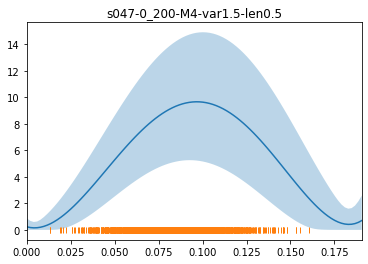

In [108]:
#画强度的估值图
X = domain_grid(domain, N)
lambda_mean, lower, upper = model.predict_lambda_and_percentiles(X)
lower = lower.numpy().flatten()
upper = upper.numpy().flatten()

title = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales)

plt.title(title)
plt.xlim(X.min(), X.max())
#plt.ylim(0, 15)
plt.plot(X, lambda_mean)
plt.fill_between(X.flatten(), lower, upper, alpha=0.3)
plt.plot(events, np.zeros_like(events), '|')
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


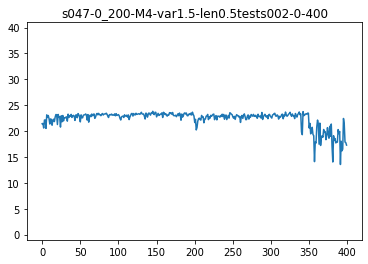

In [109]:
#测试用户数据
test_uset = 's002'
test_data_str = 0
test_data_end = 400


#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)
#print (test_data_likelihood)

title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + 'test' + test_uset + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
x_aix = range(test_data_end)
plt.ylim(-1, 41)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


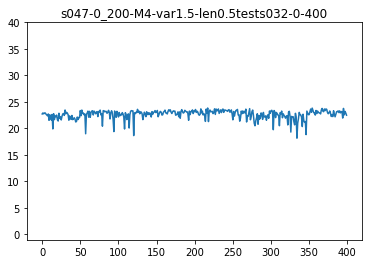

In [110]:
#测试用户数据
test_uset = 's032'
test_data_str = 0
test_data_end = 400


#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)
#print (test_data_likelihood)

title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + 'test' + test_uset + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
x_aix = range(test_data_end)
plt.ylim(-1, 40)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


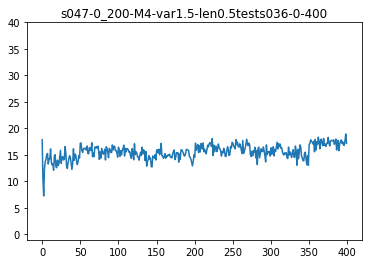

In [111]:
#测试用户数据
test_uset = 's036'
test_data_str = 0
test_data_end = 400


#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)
#print (test_data_likelihood)

title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + 'test' + test_uset + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
x_aix = range(test_data_end)
plt.ylim(-1, 40)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


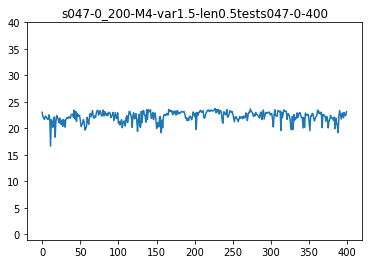

In [112]:
#测试用户数据
test_uset = 's047'
test_data_str = 0
test_data_end = 400


#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)
#print (test_data_likelihood)

title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + 'test' + test_uset + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
x_aix = range(test_data_end)
plt.ylim(-1, 40)
plt.plot(x_aix, test_data_all)
plt.show()

test num is: 0
test num is: 50
test num is: 100
test num is: 150
test num is: 200
test num is: 250
test num is: 300
test num is: 350


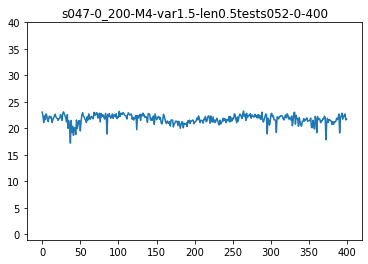

In [113]:
#测试用户数据
test_uset = 's052'
test_data_str = 0
test_data_end = 400


#画预测图
test_data_all = []
for i in range(0,test_data_end):     #预测值显示
    events_for_test, _ = build_data(test_uset, test_data_str+i, test_data_str + i + 1, filename)
    events_for_test = np.array(events_for_test, float).reshape(-1, 1)
    test_data_likelihood = model.predict_y(events_for_test, domain, N)
    test_data_all.append(test_data_likelihood)
    if i%50 == 0:
        print('test num is:',i)
#print (test_data_likelihood)

title2 = object_user+'-'+str(object_data_str)+'_'+str(object_data_end)+'-M'+ str(inducing_num) + '-var'+ str(variance) + '-len' + str(lengthscales) + 'test' + test_uset + '-' + str(test_data_str) + '-' + str(test_data_end)
plt.title(title2)
x_aix = range(test_data_end)
plt.ylim(-1, 40)
plt.plot(x_aix, test_data_all)
plt.show()